<a href="https://colab.research.google.com/github/sayakpaul/FunMatch-Distillation/blob/main/tfrecords_pets37.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os

tfds.disable_progress_bar()

## Load [Pets37](https://www.robots.ox.ac.uk/~vgg/data/pets/) dataset

In [ ]:
train_ds, validation_ds, test_ds = tfds.load(
    "oxford_iiit_pet",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)

print(f"Number of training examples: {tf.data.experimental.cardinality(train_ds)}")
print(f"Number of validation examples: {tf.data.experimental.cardinality(validation_ds)}")
print(f"Number of test examples: {tf.data.experimental.cardinality(test_ds)}")

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompletePOQ6GK/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompletePOQ6GK/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.
Number of training examples: 3312
Number of validation examples: 368
Number of test examples: 3669


## Visualization

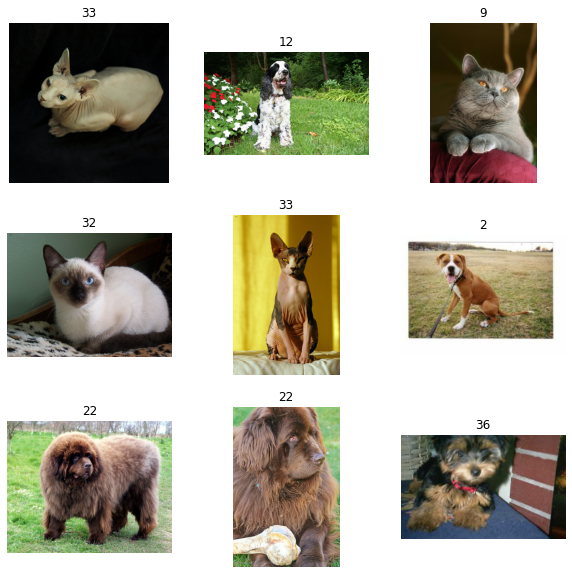

In [ ]:
# Code credits:
# https://keras.io/guides/transfer_learning/
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

## TFRecord utilities

In [ ]:
# Serialization with a relatively larger size
IMG_SIZE = 384

# Basic Preprocessing utility
def preprocess_image(image, label):
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  image = tf.cast(image, tf.float32)
  image = image
  return (image, label)

# Preprocess
train_ds = train_ds.map(preprocess_image)
validation_ds = validation_ds.map(preprocess_image)
test_ds = test_ds.map(preprocess_image)

In [ ]:
# We need to convert the image to byte strings
def recompress_image(image, label):
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return (image, label)

# Recompress the images
def recompress_dataset(dataset):
    dataset = dataset.map(recompress_image)
    dataset = dataset.batch(128) # Shard size of a single TFRecord
    return dataset

# Convert to byte strings
train_ds = recompress_dataset(train_ds)
validation_ds = recompress_dataset(validation_ds)
test_ds = recompress_dataset(test_ds)

In [ ]:
# Images are byte-strings
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

# Classes would be integers
def _int_feature(list_of_ints): 
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def to_tfrecord(img_bytes, label):  
    # print(class_num)
    feature = {
      "image": _bytestring_feature([img_bytes]), 
      "class": _int_feature([label]),             
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))

## TFRecord preparation

In [ ]:
# Prepare tfrecords
def prepare_tfrecords(dataset, split, log_every=15):
    if not os.path.exists(split):
        os.mkdir(split)
    for shard, (images, labels) in enumerate(tqdm(dataset)):
        shard_size = images.numpy().shape[0]
        filename = split + f"/{split}_pets37-" + f"{shard}-{shard_size}.tfrec"

        with tf.io.TFRecordWriter(filename) as out_file:
            for i in range(shard_size):
                example = to_tfrecord(images.numpy()[i], labels.numpy()[i])
                out_file.write(example.SerializeToString())
            if shard % log_every == 0:
                print("Wrote file {} containing {} records".format(filename, shard_size))

In [ ]:
prepare_tfrecords(train_ds, "train")

Wrote file train/train_pets37-0-128.tfrec containing 128 records
Wrote file train/train_pets37-15-128.tfrec containing 128 records



In [ ]:
prepare_tfrecords(validation_ds, "validation")

Wrote file validation/validation_pets37-0-128.tfrec containing 128 records



In [ ]:
prepare_tfrecords(test_ds, "test")

Wrote file test/test_pets37-0-128.tfrec containing 128 records
Wrote file test/test_pets37-15-128.tfrec containing 128 records



## Upload the records to a GCS Bucket

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
GCS_BUCKET = "gs://funmatch-tf" #@param {type:"string"}

!gsutil -m cp -r train validation test {GCS_BUCKET}